In [91]:
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt; import pandas as pd; import pymc as pm; import arviz as az
data = pd.read_csv('Cricket_chirps.csv')

chrips = data["Y"]
n,p=len(chrips),1
chrips = chrips.to_numpy().reshape(n,1)
x = data["X"]
x = x.to_numpy().reshape(n,1)

intercept = np.ones((n,1))
standard_x = np.c_[intercept,x]

# Replace this made up data with your data set from kaggle...
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((2,1)), cov=np.eye(2), shape=(2,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y = pm.Normal('y', mu=pm.math.dot(standard_x, betas), sigma=sigma, observed=chrips)

with MLR:
    idata = pm.sample()

From the pm sample of this linear regression model, we see that there are no divergences in the two sample chains.

array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

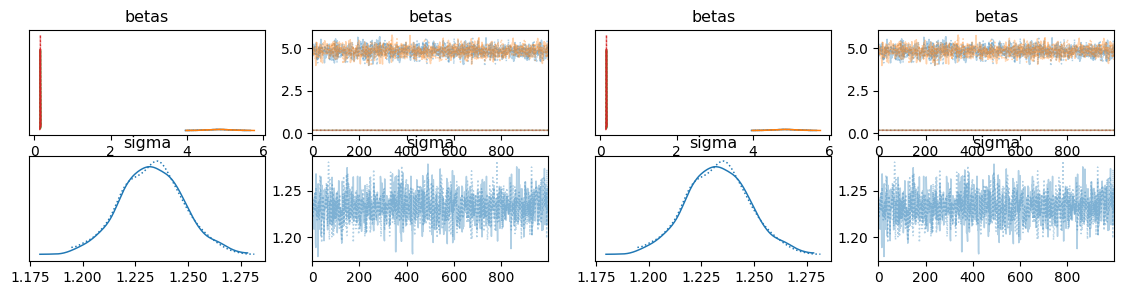

In [97]:
fig,ax = plt.subplots(2,4, figsize=(14,3))
az.plot_trace(idata, axes=ax[:2,:2]); az.plot_trace(idata, axes=ax[:2,2:])


From the traceplot, we see that our sigma prior is sensible in this cases and the sample chains converges perfectly. Thus, there are no need to alter the sigma prior because it is already sensible.

**Part 2**


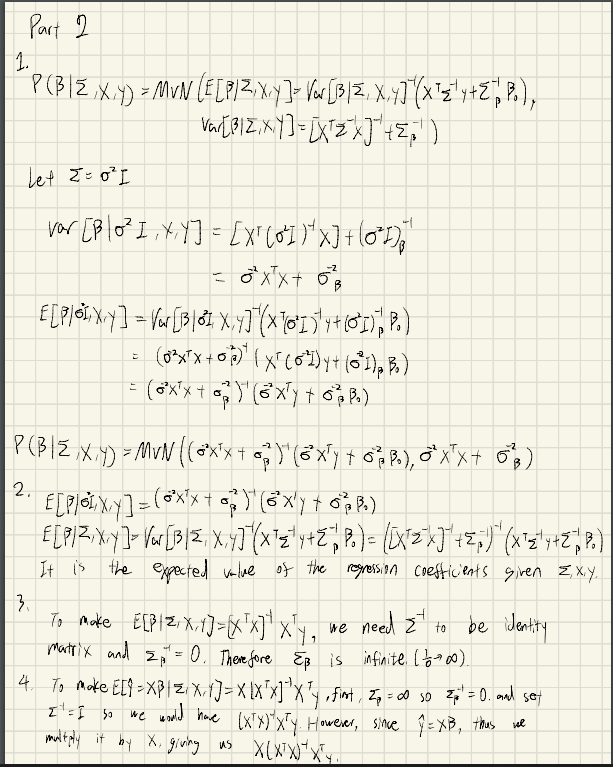
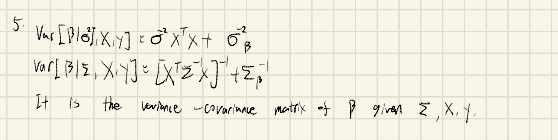

***Part 3***

In [107]:
import numpy as np; from scipy import stats
data = pd.read_csv('Cricket_chirps.csv')

chrips = data["Y"]
n,p=len(chrips),1
chrips = chrips.to_numpy().reshape(n,p)

p += 1; Psi=np.eye(p); a_cov = stats.invwishart(df=p+2, scale=Psi).rvs(1)

with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=2), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    mu = pm.MvNormal('mu', mu=np.array(0), cov=np.eye(p), shape=p);
    y = pm.MvNormal('y', mu=mu, cov=Sigma, shape=(n,1), observed=chrips)

with MNV_LKJ:
    idata = pm.sample()

/usr/local/lib/python3.10/dist-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


In [113]:
import numpy as np; from scipy import stats
data = pd.read_csv('Cricket_chirps.csv')

chrips = data["Y"]
n,p=len(chrips),1
chrips = chrips.to_numpy().reshape(n,p)

p += 1; Psi=np.eye(p); a_cov = stats.invwishart(df=p+2, scale=Psi).rvs(1)
mu_sd = 10
with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=2), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    mu = pm.MvNormal('mu', mu=17, cov=np.eye(p), shape=p);
    y = pm.MvNormal('y', mu=mu, cov=Sigma, shape=(n,1), observed=chrips)

with MNV_LKJ:
    idata = pm.sample()

In [114]:
print("Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata).items()}, end=' | ');

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


HMC Split-Rhats {'mu': array([2.0986, 2.0987]), 'packed_L': array([2.4725, 2.4724, 2.4588]), 'Sigma': array([[2.4725, 2.4725],
       [2.4725, 2.4724]])} | 

After replacing the prior with a more sensible prior, we see that there are no longer divergence for both of the sample chains. However, it is worth noticing that the Split-Rhats is quite high for the chains.